In [1]:
!pip install yfinance

In [2]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.1.0
Uninstalling gdown-5.1.0:
  Successfully uninstalled gdown-5.1.0
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [3]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf

import time
from datetime import date

# 0) Dataset for Modeling: Final Preparations

## 0.1) Importing data from Drive & defining variable sets
* automated version need to have a daily updated file/database entries

In [4]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/




Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=257fb661-f699-464b-ba30-3be5761c38d6
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:01<00:00, 83.8MB/s]


In [5]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [7]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'Ticker',
       'Year', 'Month', 'Weekday',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=202)

In [8]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [9]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [10]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [11]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [12]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [13]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

In [14]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [15]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [16]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')


Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [17]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [18]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [19]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['growth_future_5d', 'is_positive_growth_5d_future']

In [20]:
df_full.Ticker.nunique()

33

In [21]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


In [22]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


In [23]:
# let look at the features count and size:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


## 0.2) [Code snippet 1] Generating dummies

In [24]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [25]:
# dummy variables are not generated from Date and numeric variables
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [26]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [27]:
# TODO 1: define more categorical features, e.g. all combinations for <September+weekday>  (you'll see that September is actually an important dummy in one of the models)

# Question 1 (1 point): Dummies on Month and Week-of-Month

**Find the ABSOLUTE CORRELATION VALUE of the most correlated dummy <month-week_of_month> with the binary outcome variable `is_positive_growth_5d_future`?**

In [28]:
df.loc[:,'month_wom'] = df['Date'].apply(lambda d: f'{d.strftime("%B")}_w{(d.day-1) // 7 + 1}')

<ipython-input-28-011e4ea86d9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'month_wom'] = df['Date'].apply(lambda d: f'{d.strftime("%B")}_w{(d.day-1) // 7 + 1}')


In [29]:
CATEGORICAL = CATEGORICAL+['month_wom']
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [30]:
df[CATEGORICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Month        182675 non-null  object
 1   Weekday      182675 non-null  object
 2   Ticker       182675 non-null  object
 3   ticker_type  182675 non-null  object
 4   month_wom    182675 non-null  object
dtypes: object(5)
memory usage: 8.4+ MB


In [31]:
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [32]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [33]:
DUMMIES = dummy_variables.keys().to_list()
WOM_DUMMIES = [d for d in DUMMIES if d.startswith('month_wom_')]
WOM_DUMMIES

['month_wom_April_w1',
 'month_wom_April_w2',
 'month_wom_April_w3',
 'month_wom_April_w4',
 'month_wom_April_w5',
 'month_wom_August_w1',
 'month_wom_August_w2',
 'month_wom_August_w3',
 'month_wom_August_w4',
 'month_wom_August_w5',
 'month_wom_December_w1',
 'month_wom_December_w2',
 'month_wom_December_w3',
 'month_wom_December_w4',
 'month_wom_December_w5',
 'month_wom_February_w1',
 'month_wom_February_w2',
 'month_wom_February_w3',
 'month_wom_February_w4',
 'month_wom_February_w5',
 'month_wom_January_w1',
 'month_wom_January_w2',
 'month_wom_January_w3',
 'month_wom_January_w4',
 'month_wom_January_w5',
 'month_wom_July_w1',
 'month_wom_July_w2',
 'month_wom_July_w3',
 'month_wom_July_w4',
 'month_wom_July_w5',
 'month_wom_June_w1',
 'month_wom_June_w2',
 'month_wom_June_w3',
 'month_wom_June_w4',
 'month_wom_June_w5',
 'month_wom_March_w1',
 'month_wom_March_w2',
 'month_wom_March_w3',
 'month_wom_March_w4',
 'month_wom_March_w5',
 'month_wom_May_w1',
 'month_wom_May_w2',
 'm

In [34]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [35]:
corr = df_with_dummies[['is_positive_growth_5d_future'] + WOM_DUMMIES].corr()
corr['is_positive_growth_5d_future'].abs().sort_values(ascending=False).head().round(3)

is_positive_growth_5d_future    1.000
month_wom_September_w3          0.035
month_wom_March_w4              0.026
month_wom_October_w5            0.026
month_wom_February_w3           0.025
Name: is_positive_growth_5d_future, dtype: float64

# Question 2 (2 points): Define new "hand" rules on macro and technical indicators variables

**What is the precision score for the best of the NEW predictions (pred3 or pred4), rounded to 3 digits after the comma?**

Let's utilize the knowledge from the visualised tree (clf10) (Code Snippet 5: 1.4.4 Visualisation):

In [36]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [37]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [38]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [39]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [40]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"

#pred3_manual_gdp_fastd: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
new_df['pred3'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >= 0.251)).astype(int)

#pred4_manual_gdp_wti_oil: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)
new_df['pred4'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [41]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

# generate columns is_correct_
for pred in PREDICTIONS:
  new_df[f'is_correct_{pred}'] =  (new_df[pred] == new_df.is_positive_growth_5d_future).astype(int)

IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]

new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_5d_future']]

,pred3,pred4,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
3490,0,0,1,1,0
3491,0,0,1,1,0
3492,0,0,1,1,0
3493,0,0,1,1,0
3494,0,0,0,0,1
...,...,...,...,...,...
5422,1,0,0,1,0
5423,1,0,0,1,0
5424,1,0,0,1,0
5425,1,0,0,1,0


In [42]:
for i,column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter = (new_df.split=='test') & (new_df[prediction_column]==1)
  print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
  print(new_df[filter][is_correct_column].value_counts())
  print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))

  print('---------')

Prediction column:pred3 , is_correct_column: is_correct_pred3
is_correct_pred3
1    16560
0    13262
Name: count, dtype: int64
is_correct_pred3
1    0.555295
0    0.444705
Name: count, dtype: float64
---------
Prediction column:pred4 , is_correct_column: is_correct_pred4
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: float64)
---------


# Question 3 (1 point): Unique correct predictions from a 10-levels deep Decision Tree Classifier (pred5_clf_10)

**What is the total number of records in the TEST dataset when the new prediction pred5_clf_10 is better than all 'hand' rules (pred0..pred4)?**

In [43]:
new_df = df_with_dummies.copy()

In [44]:
# generate manual predictions
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)

#pred3_manual_gdp_fastd: (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
new_df['pred3'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >= 0.251)).astype(int)

#pred4_manual_gdp_wti_oil: (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)
new_df['pred4'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [45]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3',
 'pred4']

In [46]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_5d_future).astype(int)

In [47]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [49]:
# Decision Tree doesn't like too large and inf. values
import numpy as np

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_infinite_values(X)

In [50]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape}')

length: X_train (152846, 302),  X_test (29829, 302)


In [51]:
# Can't have +-inf values . E.g. ln(volume)=-inf when volume==0 => substitute with 0

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape}')

length: X_train_imputed (152846, 302),  X_test_imputed (29829, 302)


In [52]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)

In [53]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]

In [54]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,  random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [55]:
%%time
# drop 2 columns before fitting the tree, but we need those columns later for joins
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

CPU times: user 25.4 s, sys: 307 ms, total: 25.7 s
Wall time: 27.8 s


In [56]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series, y_test: pd.Series):
  try:
    # Predict the target variable on the test data
    y_pred = clf.predict(df_X)

    max_depth = clf.tree_.max_depth
    # Print the maximum depth
    print("Maximum depth of the decision tree:", max_depth)

    # Calculate the accuracy/precision of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f'Accuracy ={accuracy}, precision = {precision}')

    # resulting df
    result_df = pd.concat([new_df, pd.Series(y_pred, index=new_df.index, name='pred5_clf_10')], axis=1)
  except Exception as e:
    print(e)
    result_df = None

  return result_df

In [57]:
# concat dfs X_train_imputed with X_test_imputed
X_all = pd.concat([X_train_imputed, X_test_imputed])

In [58]:
X_all.shape

(182675, 301)

In [59]:
y_all = pd.concat([y_train, y_test])
y_all.shape

(182675,)

In [60]:
pred10 = predict_decision_tree(clf_10, X_all.drop(['Date','Ticker'],axis=1), y_all, y_all)

Maximum depth of the decision tree: 10
Accuracy =0.6026330915560422, precision = 0.5885134021298342


In [61]:
#create a new col in pred10 named 'is_correct_pred5'
pred10['is_correct_pred5'] = (pred10.pred5_clf_10 == pred10.is_positive_growth_5d_future).astype(int)

In [62]:
#create a new col in pred10 named 'only_pred5_is_correct' with several conditions: is_positive_growth_5d_future AND is_correct_pred5 should be equal 1, while all other predictions is_correct_pred0..is_correct_pred4 should be equal to 0.
pred10['only_pred5_is_correct'] = (
    (pred10.is_positive_growth_5d_future == 1) &
    (pred10.is_correct_pred5 == 1) &
    (pred10.is_correct_pred0 == 0) &
    (pred10.is_correct_pred1 == 0) &
    (pred10.is_correct_pred2 == 0) &
    (pred10.is_correct_pred3 == 0) &
    (pred10.is_correct_pred4 == 0)
).astype(int)

In [63]:
pred10['only_pred5_is_correct'].value_counts()

only_pred5_is_correct
0    180513
1      2162
Name: count, dtype: int64

In [64]:
pred10_test = pred10[pred10['split'] == 'test']
pred10_test['only_pred5_is_correct'].value_counts()

only_pred5_is_correct
0    29828
1        1
Name: count, dtype: int64

# Question 4: (2 points) Hyperparameter tuning for a Decision Tree

**What is the optimal tree depth (from 1 to 20) for a DecisionTreeClassifier?**

In [65]:
!pip install tqdm

In [66]:
from tqdm.notebook import tqdm

DEPTHS = range(1,21)
PRECISION = {}

for depth in tqdm(DEPTHS):
  clf, _ = fit_decision_tree(X_train_imputed.drop(['Date','Ticker'],axis=1), y_train, max_depth=depth)
  y_pred = clf.predict(X_test_imputed.drop(['Date','Ticker'],axis=1))
  precision = precision_score(y_test, y_pred)
  PRECISION[f'max_depths_{depth}'] = precision

  0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
sorted_PRECISION = {k: round(v, 3) for k, v in sorted(PRECISION.items(), key=lambda item: item[1], reverse=True)}
sorted_PRECISION

{'max_depths_15': 0.586,
 'max_depths_14': 0.584,
 'max_depths_17': 0.577,
 'max_depths_20': 0.573,
 'max_depths_16': 0.572,
 'max_depths_12': 0.572,
 'max_depths_6': 0.571,
 'max_depths_13': 0.571,
 'max_depths_9': 0.57,
 'max_depths_7': 0.568,
 'max_depths_8': 0.568,
 'max_depths_18': 0.568,
 'max_depths_11': 0.567,
 'max_depths_10': 0.565,
 'max_depths_19': 0.564,
 'max_depths_5': 0.555,
 'max_depths_2': 0.555,
 'max_depths_4': 0.555,
 'max_depths_1': 0.555,
 'max_depths_3': 0.555}

In [68]:
# import matplot
import matplotlib.pyplot as plt

In [76]:
clf_15, _ = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=15)

In [77]:

feature_importances = pd.DataFrame(clf_15.feature_importances_,
                                   index = X_train_imputed.drop(['Date','Ticker'],axis=1).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

<Figure size 1000x800 with 0 Axes>

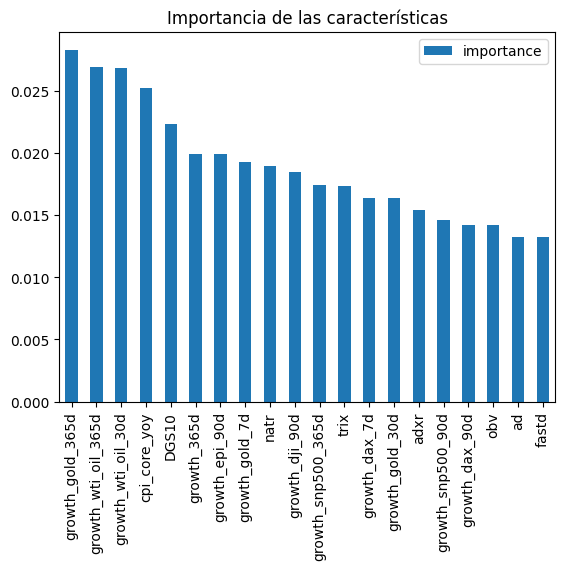

In [78]:
plt.figure(figsize=(10, 8))
feature_importances.head(20).plot(kind='bar')
plt.title("Importancia de las características")
plt.show()


In [79]:
print(feature_importances.head(10))

                     importance
growth_gold_365d       0.028316
growth_wti_oil_365d    0.026872
growth_wti_oil_30d     0.026797
cpi_core_yoy           0.025237
DGS10                  0.022334
growth_365d            0.019906
growth_epi_90d         0.019883
growth_gold_7d         0.019277
natr                   0.018924
growth_dji_90d         0.018483
